# In-between uncertainty

In [4]:
import jax
import numpy as np
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
from functools import partial
import matplotlib.pyplot as plt

In [5]:
from rebayes_mini.methods import low_rank_last_layer as l3rfilter

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
sns.set_palette("colorblind")

In [8]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

plt.rcParams["font.size"] = 12
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
# plt.rc("text", usetex=True)

In [9]:
jnp.set_printoptions(suppress=True, precision=5, linewidth=200)

In [10]:
qlow = 0.25
qhigh = 0.75

## Test function

In [11]:
def sample_fn(key, n_samples, noise=0.05):
    key_W, key_b, key_x, key_y = jax.random.split(key, 4)


    W = jax.random.normal(key_W, (30, 1))
    b = jax.random.normal(key_b, (30, 1)) * 2 * jnp.pi

    x1, x2 = jax.random.normal(key_x, (2, n_samples))
    y_err = jax.random.normal(key_y, n_samples)
    
    x = 5 * jnp.sign(x1) + x2.clip(-2, 2)
    y = jnp.cos(W * x + b).sum(axis=0) / 5.0 + noise * y_err

    return x / 10,  y

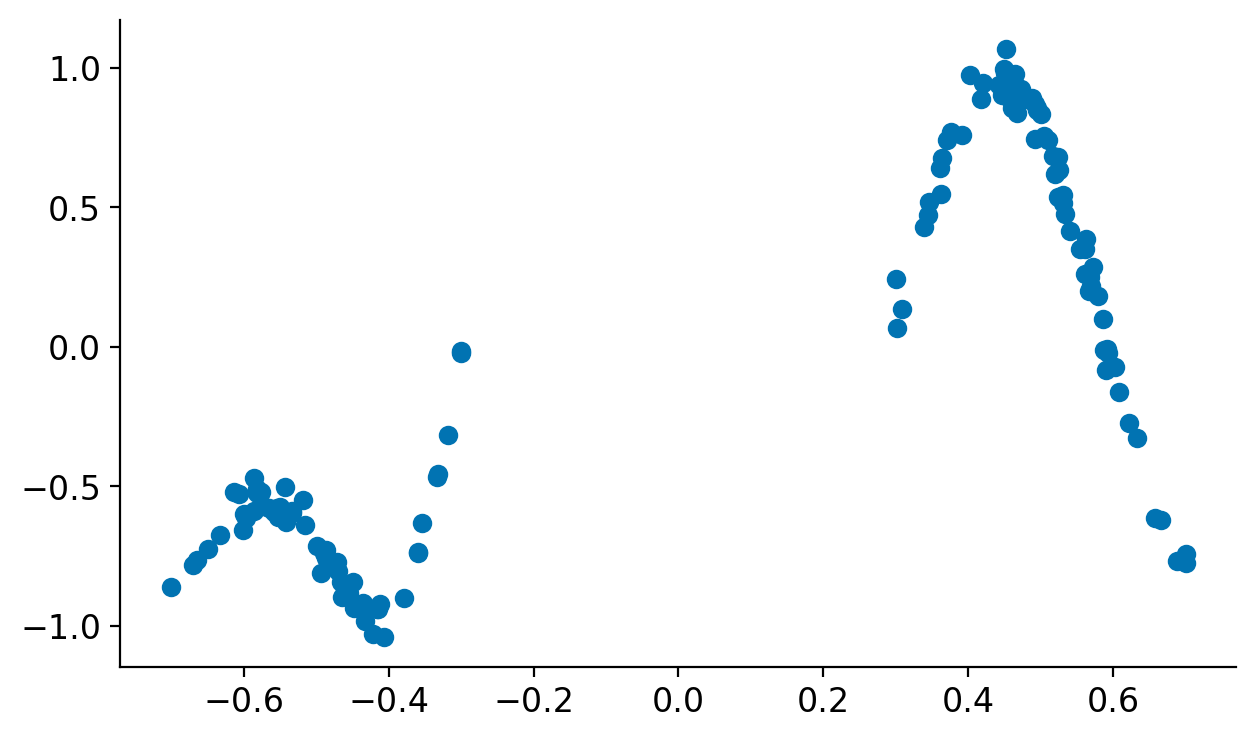

In [12]:
key = jax.random.PRNGKey(314)
key_sample, key_train = jax.random.split(key)
n_samples = 128

xrange = jnp.linspace(-0.8, 0.8, 200)
x_samples, y_samples = sample_fn(key_sample, n_samples)
plt.scatter(x_samples, y_samples)

## Single-pass LL-LRKF

In [13]:
class MLP(nn.Module):
    n_hidden: int = 64

    @nn.compact
    def encode(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        return x

    @nn.compact
    def __call__(self, x):
        x = self.encode(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

In [14]:
%%time
model = MLP()
params_init = model.init(key_train, x_samples[:, None])

def cov_fn(y): return 0.05 ** 2
agent = l3rfilter.LowRankLastLayer(
    model.apply, cov_fn, dynamics_hidden=0.0, dynamics_last=0.0, rank=50
)
bel_init = agent.init_bel(
    params_init, cov_hidden=0.01, cov_last=50.0, low_rank_diag=False
)

bel, _ = agent.scan(bel_init, y_samples, x_samples[:, None])
bel = jax.block_until_ready(bel)

CPU times: user 4.92 s, sys: 142 ms, total: 5.06 s
Wall time: 3.42 s


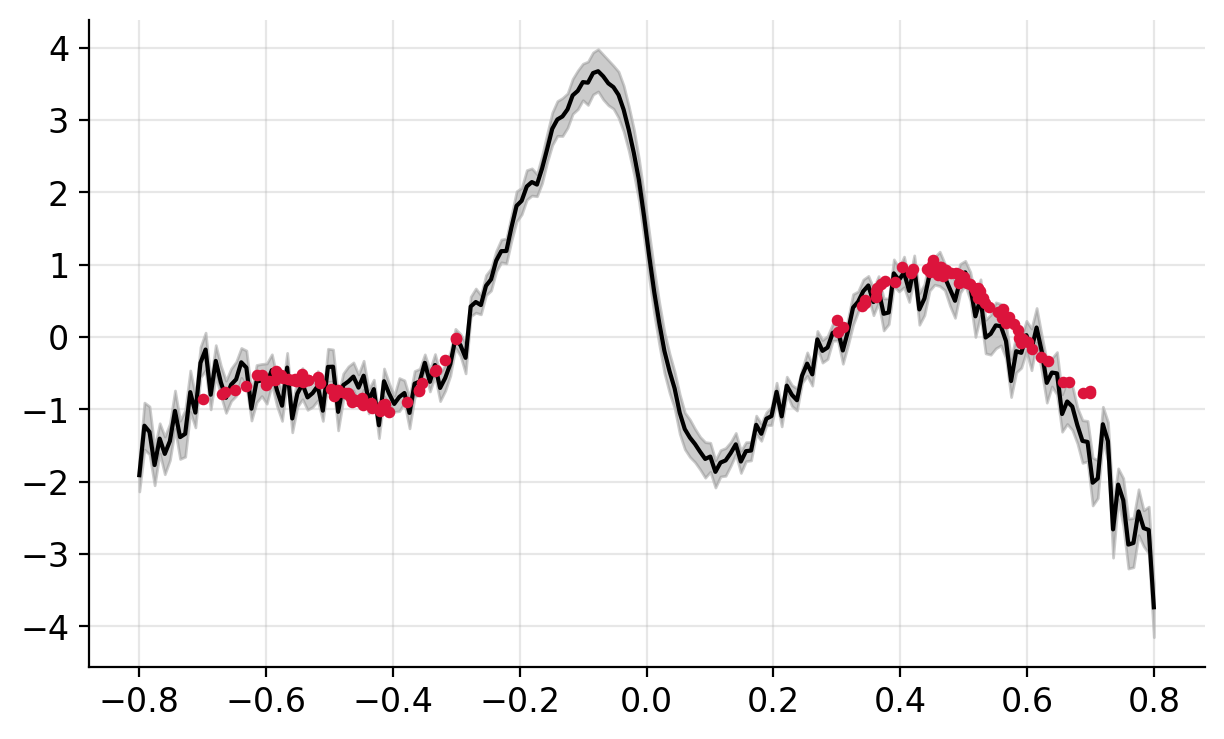

In [15]:
sample_params = agent.sample_params(key_sample, bel, (100,))
eval_samples = jax.vmap(agent.mean_fn, in_axes=(None, 0, None))(bel.mean_hidden, sample_params, xrange[:, None]).squeeze()

lbound = np.quantile(eval_samples, qlow, axis=0)
ubound = np.quantile(eval_samples, qhigh, axis=0)
meanpred = eval_samples.mean(axis=0)


plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.4)

plt.plot(xrange, meanpred, c="black")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)
plt.grid(alpha=0.3)

## Coupling with GPs

In [16]:
params_final = agent.rfn(jnp.r_[bel.mean_hidden, bel.mean_last])

In [17]:
X_enc = model.apply(params_final, x_samples[:, None], method=MLP.encode)
Xtest_enc = model.apply(params_final, xrange[:, None], method=MLP.encode)

In [18]:
@partial(jax.vmap, in_axes=(0, None, None))
@partial(jax.vmap, in_axes=(None, 0, None))
def kgauss(u, v, gamma2=1.0):
    return jnp.exp(-jnp.linalg.norm(u - v) ** 2 / (2 * gamma2))

In [19]:
gamma2 = 0.5 ** 2
var_train = kgauss(X_enc, X_enc, gamma2)
cov_test_train = kgauss(Xtest_enc, X_enc, gamma2)
var_test = kgauss(Xtest_enc, Xtest_enc, gamma2)

In [20]:
K = jnp.linalg.solve(var_train + 0.05 ** 2 * jnp.eye(n_samples), cov_test_train.T).T
mu_pred = K @ y_samples

In [21]:
sigma_pred = var_test - K @ var_train @ K.T
sigma_diag = jnp.diag(sigma_pred)

lbound = mu_pred - 2 * sigma_diag
ubound = mu_pred + 2 * sigma_diag

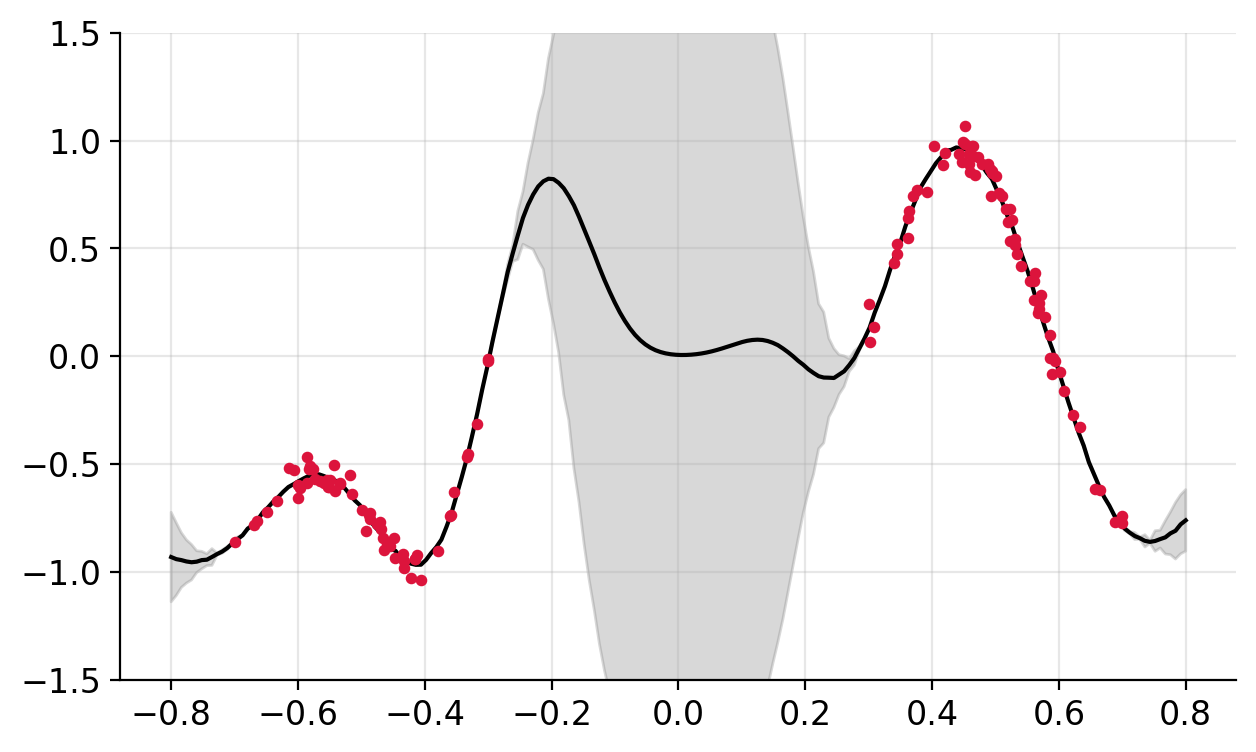

In [22]:
plt.plot(xrange, mu_pred, color="black")
plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.3)

plt.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)
plt.ylim(-1.5, 1.5)
plt.grid(alpha=0.3)

# Last-layer methods

In [76]:
import optax
from flax.training.train_state import TrainState
from vbll.jax.layers import Regression

## MLP

In [77]:
mlp = MLP()
params_init = model.init(key_train, x_samples[:, None])
jax.tree.map(jnp.shape, params_init)

{'params': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)},
  'Dense_1': {'bias': (64,), 'kernel': (64, 64)},
  'Dense_2': {'bias': (64,), 'kernel': (64, 64)},
  'Dense_3': {'bias': (64,), 'kernel': (64, 64)},
  'last_layer': {'bias': (1,), 'kernel': (64, 1)}}}

In [88]:
@jax.value_and_grad
def eval_grads(params):
    yhat = mlp.apply(params, x_samples[:, None]).squeeze()
    errs = jnp.power(yhat - y_samples, 2)
    return errs.mean()

In [89]:
state = TrainState.create(
    apply_fn=eval_grads,
    params=params_init,
    tx=optax.adamw(1e-3)
)

In [90]:
def step(state, _):
    loss, grads = state.apply_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [93]:
n_epochs = 2000
epochs = jnp.arange(n_epochs)
state_final, losses = jax.lax.scan(step, state, epochs)

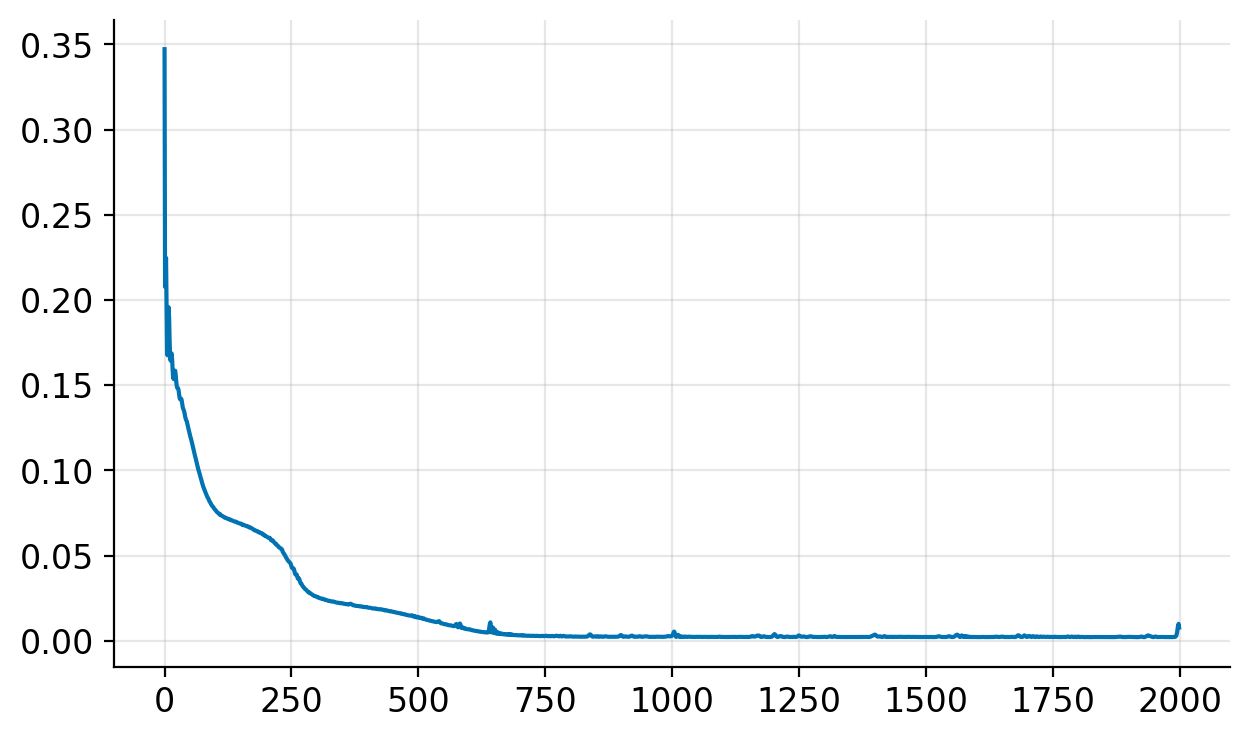

In [94]:
plt.plot(losses)
plt.grid(alpha=0.3)
# plt.yscale("log")

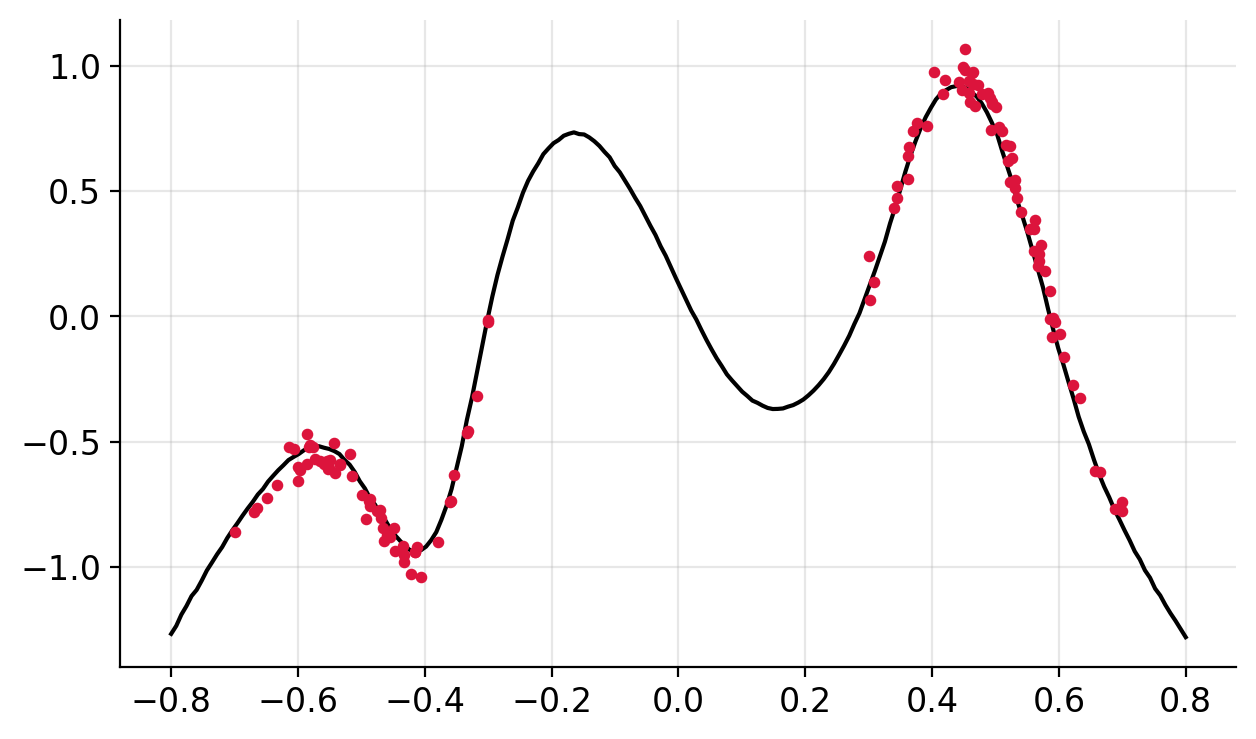

In [99]:
yhat = mlp.apply(state_final.params, xrange[:, None])
plt.plot(xrange, yhat, c="black")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)
plt.grid(alpha=0.3)

## VBLL

Sources:
1. [Notebook example in Pytorch](https://colab.research.google.com/github/VectorInstitute/vbll/blob/main/docs/tutorials/VBLL_Regression.ipynb#scrollTo=dOUWXc9HLI0T)
2. [Regression layer definition](https://github.com/VectorInstitute/vbll/blob/main/vbll/jax/layers/regression.py)

In [289]:
class VBLLMLP(nn.Module):
    n_hidden: int = 64

    @nn.compact
    def encode(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        return x

    @nn.compact
    def __call__(self, x):
        x = self.encode(x)
        x = Regression(
            in_features=self.n_hidden, out_features=1,
            wishart_scale=0.1,
            regularization_weight=1 / len(y_samples)
        )(x)
        return x

In [290]:
x_samples.shape

(128,)

In [291]:
vbll = VBLLMLP()
params_init = vbll.init(key_train, x_samples[:, None])
jax.tree.map(jnp.shape, params_init)

{'params': {'Dense_0': {'bias': (64,), 'kernel': (1, 64)},
  'Dense_1': {'bias': (64,), 'kernel': (64, 64)},
  'Dense_2': {'bias': (64,), 'kernel': (64, 64)},
  'Dense_3': {'bias': (64,), 'kernel': (64, 64)},
  'Regression_0': {'W_logdiag': (1, 64),
   'W_mean': (1, 64),
   'W_offdiag': (1, 64, 64),
   'noise_logdiag': (1,),
   'noise_mean': (1,)}}}

### Train loop

In [277]:
@jax.value_and_grad
def eval_grads(params):
    res = vbll.apply(params, x_samples[:, None])
    return res.train_loss_fn(y_samples[:, None])

In [278]:
state_init = TrainState.create(
    apply_fn=eval_grads,
    params=params_init,
    tx=optax.adamw(1e-3)
)

In [279]:
def step(state, _):
    loss, grads = state.apply_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [280]:
n_epochs = 10_000
epochs = jnp.arange(n_epochs)
state_final, losses = jax.lax.scan(step, state_init, epochs)

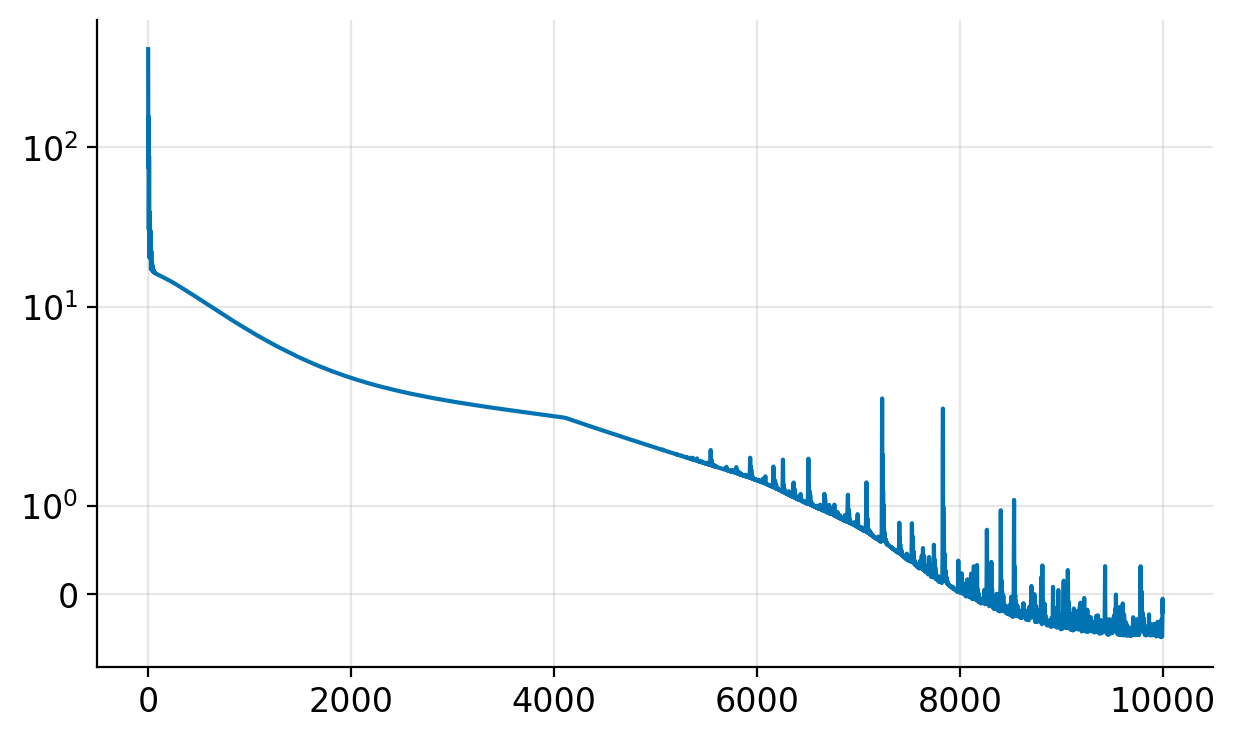

In [287]:
plt.plot(losses)
plt.grid(alpha=0.3)
plt.yscale("symlog")

## Posterior predictive

In [315]:
res = vbll.apply(state_final.params, xrange[:, None])
y_test_predictive = res.predictive
y_test_mu = y_test_predictive.mean
y_test_sigma = jnp.sqrt(jnp.diag(y_test_predictive.covariance))

In [316]:
lbound = y_test_mu - 2 * y_test_sigma
ubound = y_test_mu + 2 * y_test_sigma

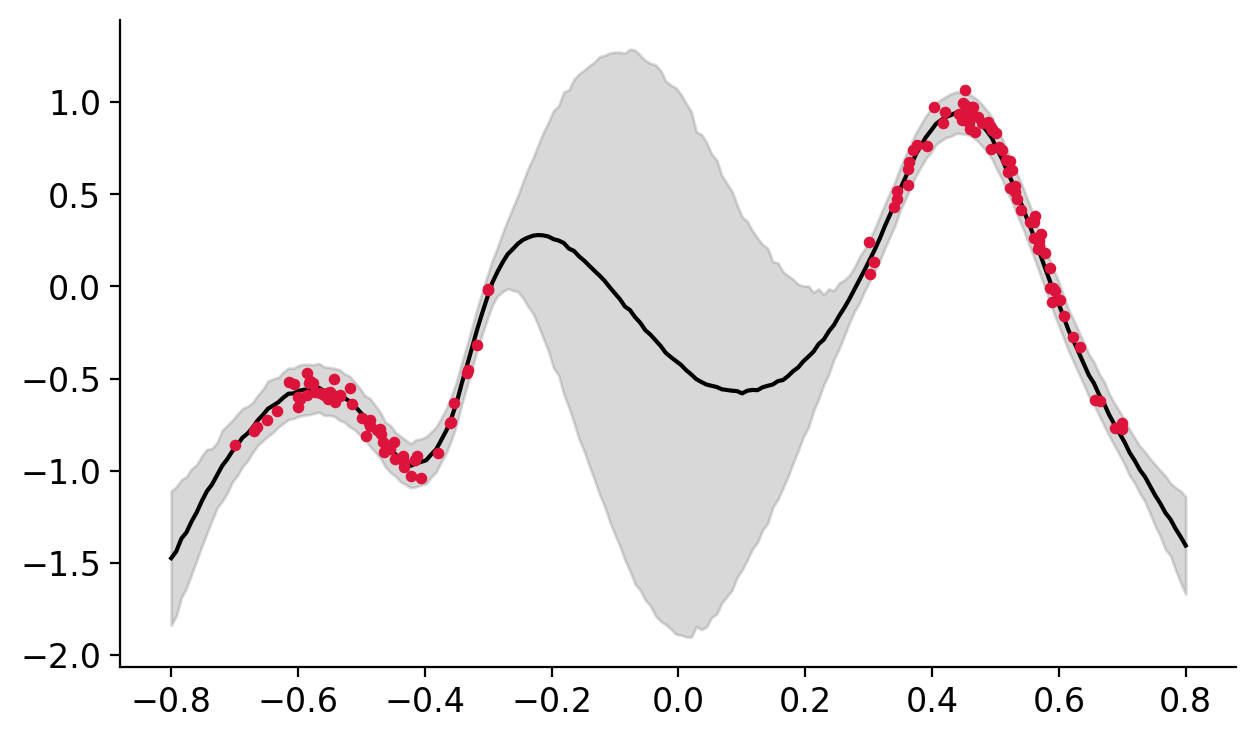

In [324]:
plt.fill_between(xrange, lbound, ubound, color="tab:gray", alpha=0.3)
plt.plot(xrange, y_test_mu, color="black")
plt.scatter(x_samples, y_samples, c="crimson", zorder=3, s=10)